### **Import libraries and load MNIST**

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from IPython.display import display
from sklearn.decomposition import KernelPCA

# For 3D scatter plot later
from mpl_toolkits.mplot3d import Axes3D

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.78MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### **Preprocess data and select digits**

In [2]:

data = mnist.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0, 1]
labels = mnist.targets.numpy()

# Use only the first 12,000 samples from the 60k dataset
data = data[:12000]
labels = labels[:12000]

# Select two digits (e.g., 3 and 7)
digits = [2, 3, 7, 8]
mask = np.isin(labels, digits)
digit_data = data[mask]
digit_labels = labels[mask]

# Compute mean image for the full selected dataset
mean_image = np.mean(digit_data, axis=0)

# Compute mean images per digit
mean_images_per_digit = {digit: np.mean(digit_data[digit_labels == digit], axis=0) for digit in digits}


## **Compute and Plot Covariance Matrix and Mean Images**

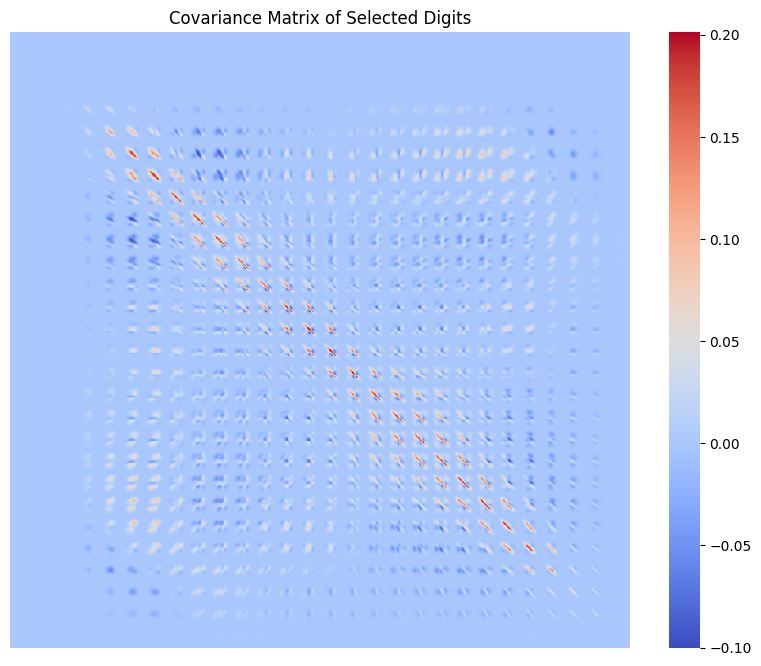

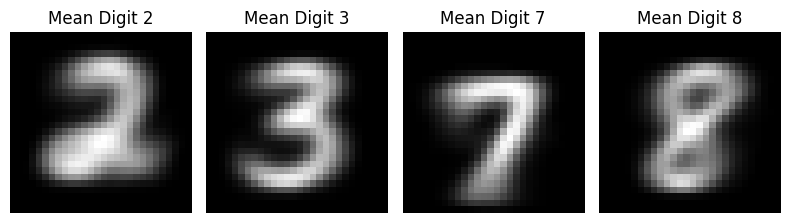

In [3]:
# Compute covariance matrix (mean-centering the data)
mean_centered = digit_data - mean_image
cov_matrix = np.cov(mean_centered, rowvar=False)

# Plot the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title("Covariance Matrix of Selected Digits")
plt.show()

# Plot mean images per digit
plt.figure(figsize=(8, 4))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(mean_images_per_digit[digit].reshape(28, 28), cmap='gray')
    plt.title(f'Mean Digit {digit}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## **Scatter plots using Kernel PCA with 2 and 3 components**

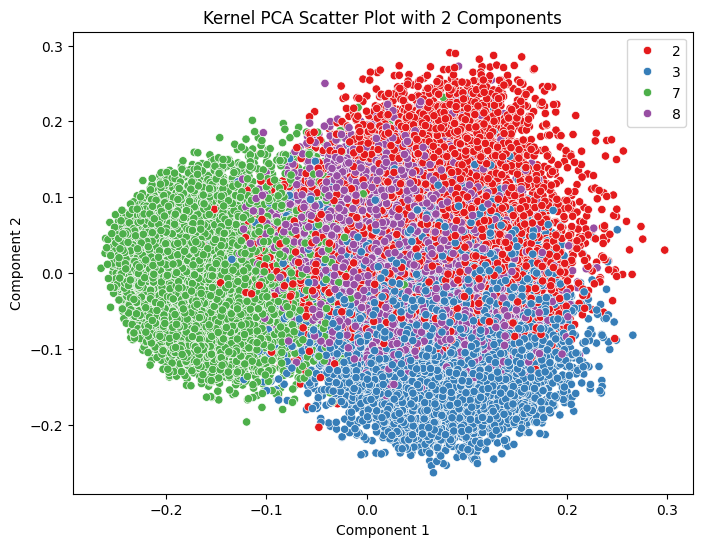

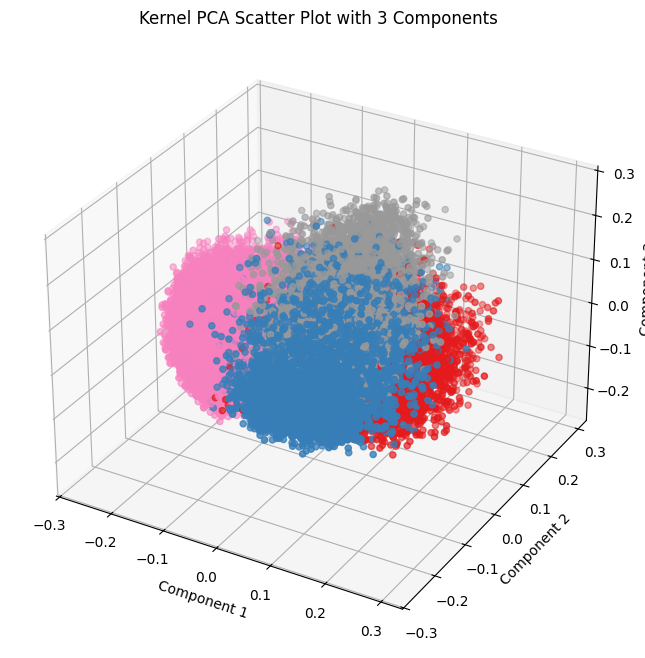

In [ ]:

# Kernel PCA with 2 components
kpca_2 = KernelPCA(n_components=2, kernel='rbf', gamma=1/784)
transformed_2 = kpca_2.fit_transform(digit_data.Τ)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=transformed_2[:, 0], y=transformed_2[:, 1], hue=digit_labels, palette='Set1', legend='full')
plt.title('Kernel PCA Scatter Plot with 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Kernel PCA with 3 components (3D scatter plot)
kpca_3 = KernelPCA(n_components=3, kernel='rbf', gamma=1/784)
transformed_3 = kpca_3.fit_transform(digit_data)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(transformed_3[:, 0], transformed_3[:, 1], transformed_3[:, 2], c=digit_labels, cmap='Set1')
ax.set_title('Kernel PCA Scatter Plot with 3 Components')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()


##**Compute Kernel PCA with 8 components, plot reconstruction error histograms, and plot the first 8 component images**

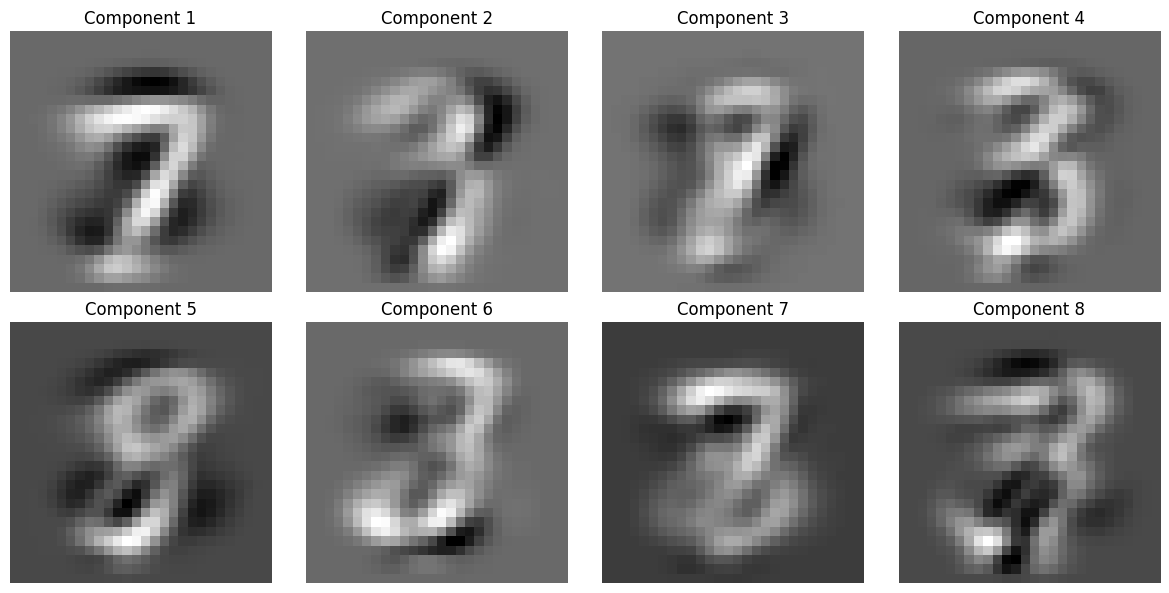

Transformed data shape (should be [n_samples, 8]): (4810, 8)


In [13]:
# Cell X:
# Compute Kernel PCA with 8 components (using gamma=0.04)
kpca_8 = KernelPCA(n_components=8, kernel='rbf', fit_inverse_transform=True, gamma=0.04)
transformed_8 = kpca_8.fit_transform(digit_data)
reconstructed_8 = kpca_8.inverse_transform(transformed_8)

# -----------------------------------------------------------------------------
# Plot the first 8 component images:
# In kernel PCA, components are not directly accessible as images.
# However, we can approximate the "component images" by taking the inverse transform
# of the canonical basis vectors in the kernel PCA feature space.
# Create an 8x8 identity matrix (each row is a basis vector)
component_basis = np.eye(8)

# Inverse transform these basis vectors to obtain approximate component images
component_images = kpca_8.inverse_transform(component_basis)

# Plot the resulting component images (reshaped to 28x28)
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(component_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Component {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Optionally, print the shape of the transformed data to confirm 8 components
print("Transformed data shape (should be [n_samples, 8]):", transformed_8.shape)




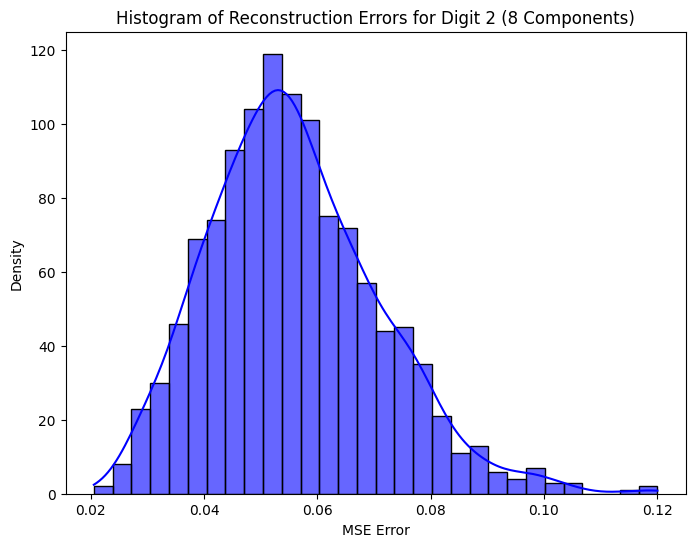

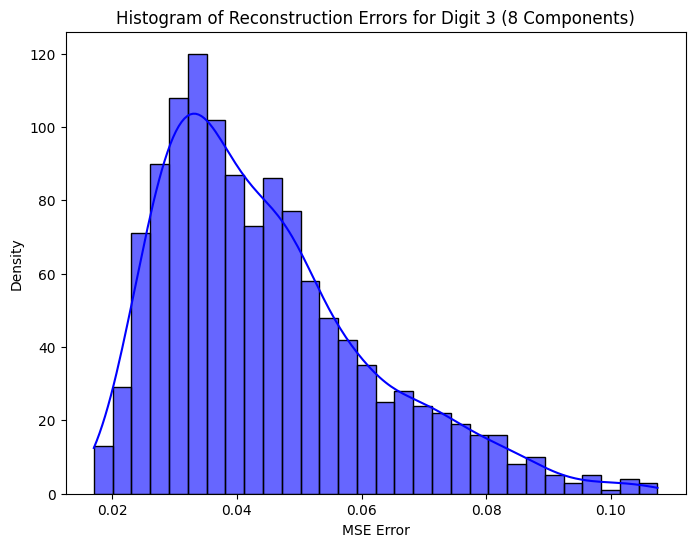

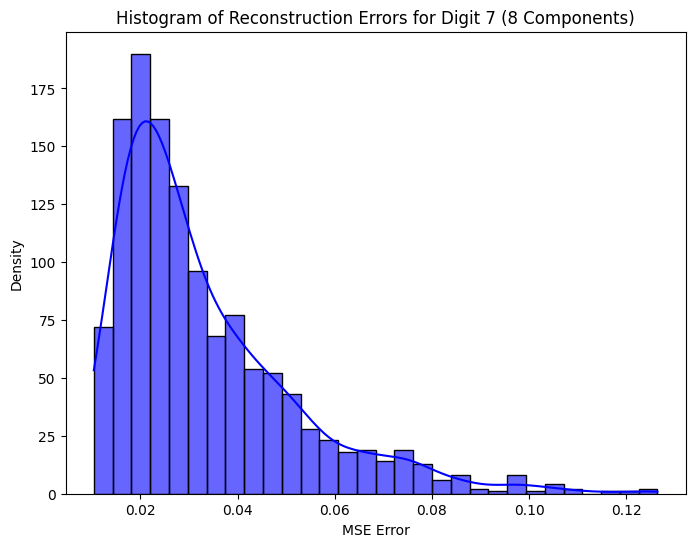

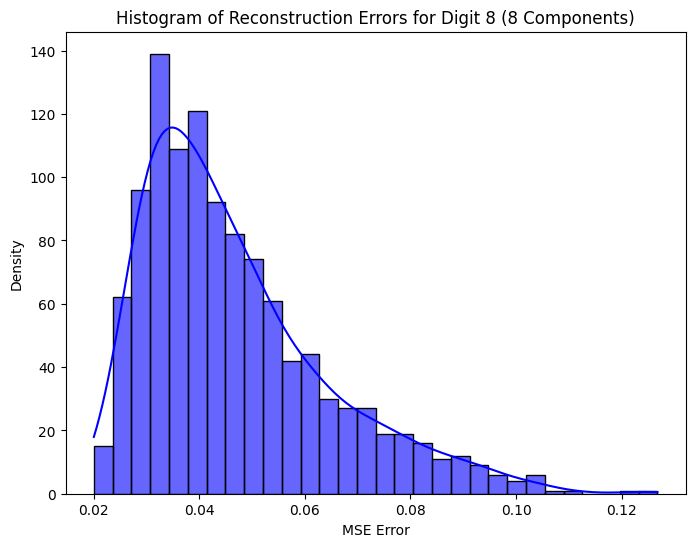

In [14]:
# Compute reconstruction errors for each sample
errors_8 = np.mean((digit_data - reconstructed_8) ** 2, axis=1)

# For each digit, plot histogram of the reconstruction errors (using 8 components)
for digit in digits:
    plt.figure(figsize=(8, 6))
    digit_errors = errors_8[digit_labels == digit]
    sns.histplot(digit_errors, kde=True, bins=30, color='blue', alpha=0.6)
    plt.title(f'Histogram of Reconstruction Errors for Digit {digit} (8 Components)')
    plt.xlabel('MSE Error')
    plt.ylabel('Density')
    plt.show()

## **Define Kernel PCA Reconstruction Function and Apply It**

In [15]:
def compute_kernel_pca_reconstructions(data, components_list, kernel='rbf', gamma=0.04):
    reconstructions = {}
    mse_list = []
    for L in components_list:
        kpca = KernelPCA(n_components=L, kernel=kernel, fit_inverse_transform=True, gamma=gamma)
        transformed = kpca.fit_transform(data)
        reconstructed = kpca.inverse_transform(transformed)
        reconstructions[L] = reconstructed
        mse = np.mean((data - reconstructed) ** 2)
        mse_list.append(mse)
        print(f'Components: {L}, MSE: {mse:.6f}')
    return reconstructions, mse_list

# Define component numbers and compute reconstructions
components_list = [1, 8, 16, 64, 256]
reconstructions, mse = compute_kernel_pca_reconstructions(digit_data, components_list, kernel='rbf', gamma=0.04)


Components: 1, MSE: 0.061368
Components: 8, MSE: 0.044875
Components: 16, MSE: 0.038369
Components: 64, MSE: 0.028706
Components: 256, MSE: 0.024678


##**Plot original vs. reconstructed images for a fixed sample of each digit. Select one fixed digit sample for each digit (first occurrence)**

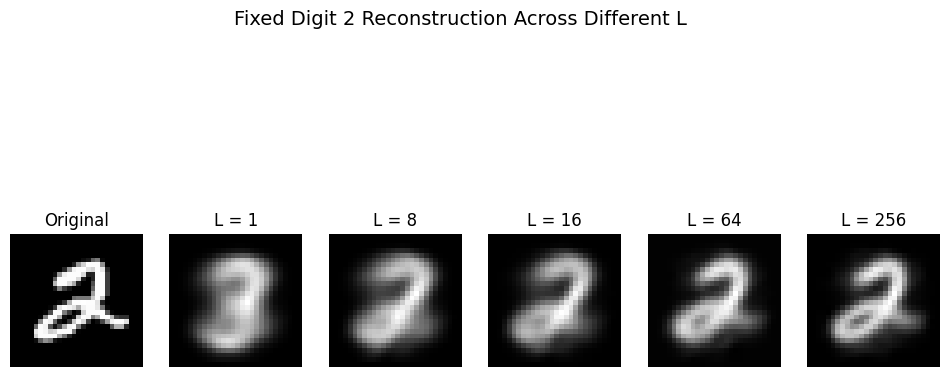

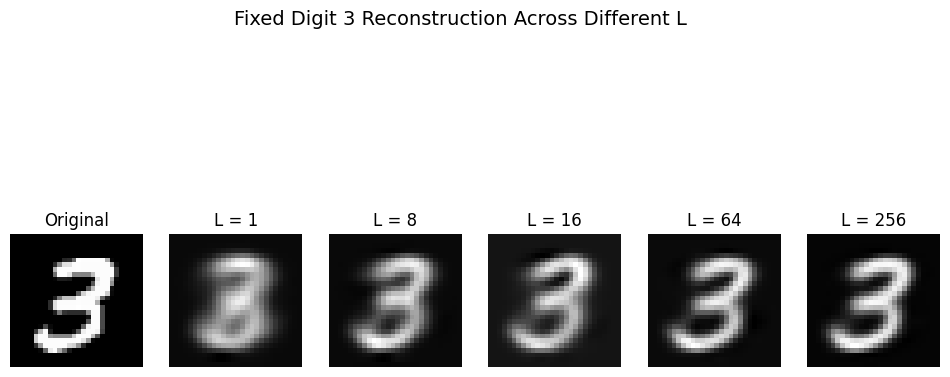

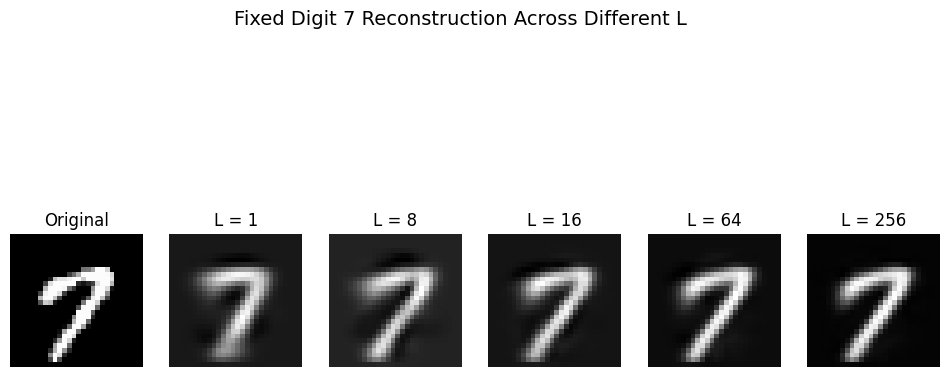

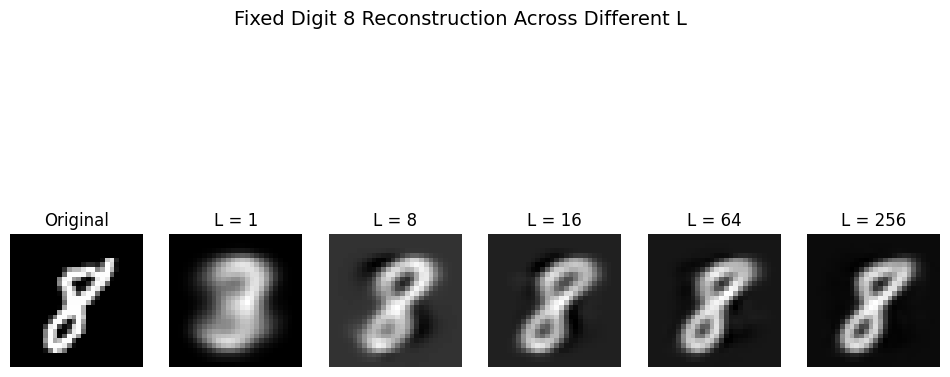

In [16]:

digit_samples = {}
for digit in digits:
    digit_samples[digit] = digit_data[np.where(digit_labels == digit)[0][0]]

def plot_fixed_reconstructions(digit_samples, reconstructions, components_list):
    for digit, original_img in digit_samples.items():
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Fixed Digit {digit} Reconstruction Across Different L', fontsize=14)

        # Plot the original image
        plt.subplot(1, len(components_list) + 1, 1)
        plt.imshow(original_img.reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot reconstructions for different component numbers
        for i, L in enumerate(components_list):
            # Use the same fixed index (first occurrence) for this digit
            idx = np.where(digit_labels == digit)[0][0]
            reconstructed_img = reconstructions[L][idx]
            plt.subplot(1, len(components_list) + 1, i + 2)
            plt.imshow(reconstructed_img.reshape(28, 28), cmap='gray')
            plt.title(f'L = {L}')
            plt.axis('off')
        plt.show()

plot_fixed_reconstructions(digit_samples, reconstructions, components_list)

## **Compute reconstruction errors per digit**

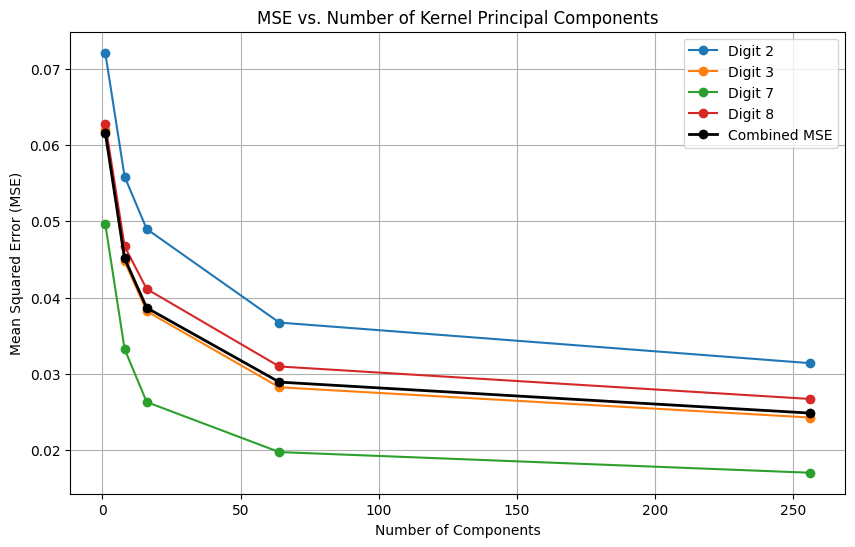

,2,3,7,8
1,0.072096,0.061957,0.049661,0.062819
8,0.055862,0.044758,0.033259,0.046721
16,0.048990,0.038213,0.026316,0.041135
64,0.036733,0.028254,0.019759,0.030978
256,0.031414,0.024290,0.017054,0.026723


In [22]:
# Compute reconstruction errors per digit
errors_per_digit = {L: {digit: [] for digit in digits} for L in components_list}
for i, label in enumerate(digit_labels):
    for L, reconstructed in reconstructions.items():
        error = np.mean((digit_data[i] - reconstructed[i]) ** 2)
        errors_per_digit[L][label].append(error)

# Prepare the figure
plt.figure(figsize=(10, 6))

# Plot MSE for each digit separately
for digit in digits:
    mse_digit = [np.mean(errors_per_digit[L][digit]) for L in components_list]
    plt.plot(components_list, mse_digit, marker='o', linestyle='-', label=f'Digit {digit}')

# Plot combined MSE (averaged over all selected digits)
mse_combined = [np.mean([np.mean(errors_per_digit[L][digit]) for digit in digits]) for L in components_list]
plt.plot(components_list, mse_combined, marker='o', linestyle='-', label='Combined MSE', color='black', linewidth=2)

# Add titles and labels
plt.title('MSE vs. Number of Kernel Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Create and display a DataFrame with mean MSE per digit
mse_per_digit_df = {L: {digit: np.mean(errors_per_digit[L][digit]) for digit in digits} for L in components_list}
mse_df = pd.DataFrame(mse_per_digit_df).T
display(mse_df)


## **Plot histograms (with KDE) of reconstruction errors for each digit across different L values**

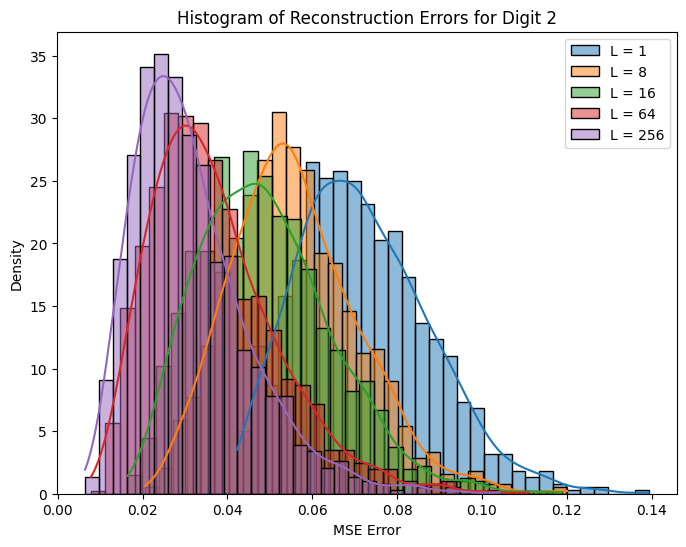

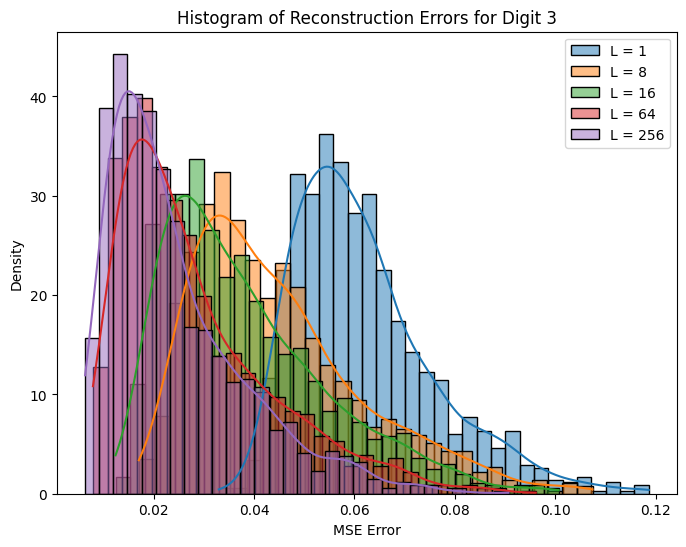

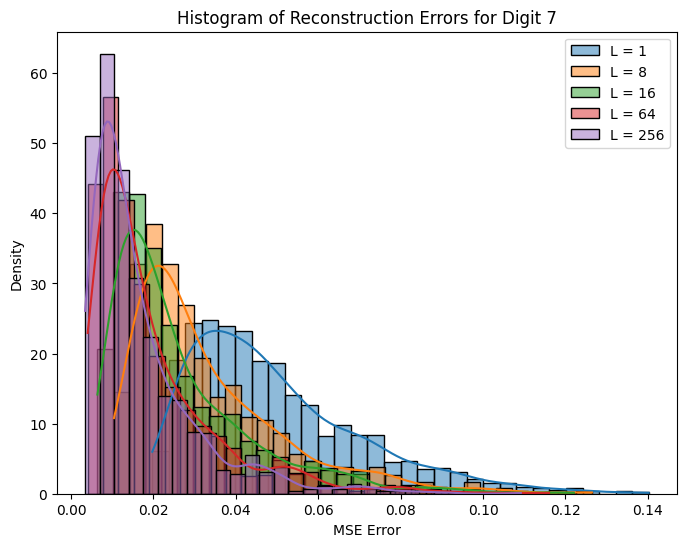

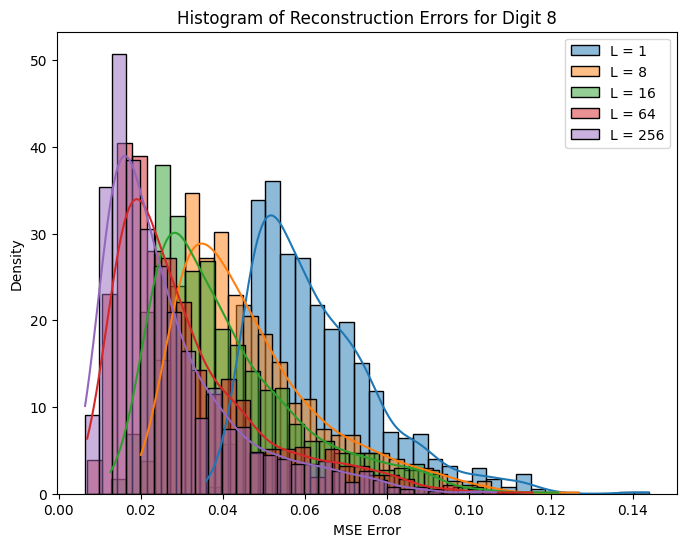

In [18]:

for digit in digits:
    plt.figure(figsize=(8, 6))
    for L in components_list:
        sns.histplot(errors_per_digit[L][digit], kde=True, label=f"L = {L}", stat="density", bins=30, alpha=0.5)
    plt.title(f"Histogram of Reconstruction Errors for Digit {digit}")
    plt.xlabel("MSE Error")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
